In [235]:
## EP1 - PSI3471
## Aluno: Leonardo Isao Komura - NUSP: 11261656

In [236]:
import cv2
import glob
import numpy as np; import sys; import os; from time import time
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dropout, Conv2D, MaxPooling2D, Dense, Flatten
from keras import optimizers
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [237]:
def findCenterAndOrientation(img):
    m = cv2.moments(img)
    cen_x = int(m["m10"]/m["m00"])
    cen_y = int(m["m01"]/m["m00"])
    theta = 0.5 * math.atan2(2*m["mu11"], m["mu20"]-m["mu02"])
    return cen_x, cen_y, theta

In [238]:
def le(diretorio,nl,nc,inic,fim):
    nclasses=len(diretorio)
    n=nclasses*(fim-inic+1)
    AX=np.empty((n,nl,nc),np.uint8);
    AY=np.empty((n,),np.uint8);
 
    j=0; k=0
    for nome in diretorio:
        for i in range(inic,fim+1):
            st = nome + " (" + str(i) + ")."+"jpg"; st = nome+"/"+st; #print(st)
            a=cv2.imread(st,cv2.IMREAD_GRAYSCALE)
            if a is None: print("Erro leitura",st); sys.exit()
            a=cv2.resize(a,(nl,nc),interpolation=cv2.INTER_AREA)
            AX[k,:,:]=a; AY[k]=j
            k+=1
        j+=1
    return AX,AY

In [239]:
def escreve(img, diretorio, inic, fim):
    dir = 0
    bias = int(img.shape[0]/5)
    for nome in diretorio:
        for i in range(inic,fim+1):
            st = nome + " (" + str(i) + ")."+"png"; st = nome+"/"+st
            cv2.imwrite(st, img[dir+i-inic])
        dir = dir+bias

In [240]:
def rotate(img):
   rotation = np.empty((img.shape))
   height, width = img.shape[1:3] 
   for i in range(img.shape[0]):
      x, y, theta = findCenterAndOrientation(img[i])
      rotM = cv2.getRotationMatrix2D(center=(x,y), angle=theta*180/math.pi, scale=1)
      rotation[i] = cv2.warpAffine(src=img[i], M=rotM, dsize=(width, height))
   return rotation 

In [241]:
diretorio=["Arborio","Basmati","Ipsala","Jasmine","Karacadag"]
nl = 125
nc = 125
AX,AY=le(diretorio,nl,nc,1,100)
qx,qy=le(diretorio,nl,nc,101,1000)

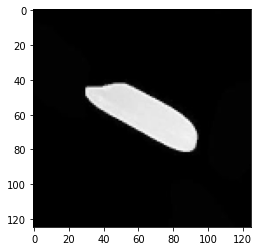

In [242]:
arborio = 0
basmati = 100
ipsala = 200
jasmine = 300
karacadag = 400

imgplot = plt.imshow(AX[jasmine+1], cmap='gray')
plt.show()

In [243]:
print(AX.shape)
print(qx.shape)

(500, 125, 125)
(4500, 125, 125)


In [244]:
AXR = rotate(AX)
qxr = rotate(qx)

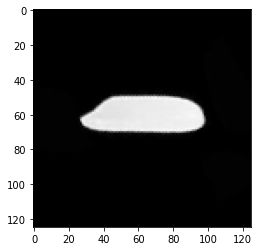

In [245]:
imgplot = plt.imshow(AXR[jasmine+1], cmap='gray')
plt.show()

In [246]:
escreve(AXR,diretorio,1,100)
escreve(qxr,diretorio,101,1000)

In [247]:
print(AXR.shape)

(500, 125, 125)


In [248]:
# Validação cruzada
from sklearn.model_selection import train_test_split
x_train, x_val, y_train1, y_val1 = train_test_split(AX, AY, test_size = 0.1, random_state=1)
print('Qtde de treino: {}'.format(len(x_train)))
print('Qtde de validação: {}'.format(len(x_val)))

Qtde de treino: 450
Qtde de validação: 50


In [249]:
y_train = keras.utils.to_categorical(y_train1, 5)
y_val = keras.utils.to_categorical(y_val1, 5)
qy2 = keras.utils.to_categorical(qy, 5)

In [250]:
model = Sequential() 
model.add(Conv2D(20, kernel_size=(5,5), activation='relu', input_shape=(125, 125, 1) )) #20x24x24
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Conv2D(40, kernel_size=(5,5), activation='relu')) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(200, activation='relu')) 
model.add(Dense(5, activation='softmax')) 

In [251]:
opt=optimizers.Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [252]:
t0=time()
history = model.fit(x_train, y_train,
                    batch_size=100,
                    epochs=10,
                    validation_data=(x_val, y_val))
t1=time(); print("Tempo de treino: %.2f s"%(t1-t0))

Epoch 1/10
5/5 [==============================] - 9s 2s/step - loss: 158.9671 - accuracy: 0.2244 - val_loss: 22.6662 - val_accuracy: 0.4200
Epoch 2/10
5/5 [==============================] - 6s 1s/step - loss: 7.5456 - accuracy: 0.6156 - val_loss: 2.6855 - val_accuracy: 0.4600
Epoch 3/10
5/5 [==============================] - 6s 1s/step - loss: 1.5657 - accuracy: 0.5356 - val_loss: 1.2864 - val_accuracy: 0.5000
Epoch 4/10
5/5 [==============================] - 6s 1s/step - loss: 0.7550 - accuracy: 0.6956 - val_loss: 0.8069 - val_accuracy: 0.6200
Epoch 5/10
5/5 [==============================] - 6s 1s/step - loss: 0.3268 - accuracy: 0.8800 - val_loss: 0.5284 - val_accuracy: 0.8400
Epoch 6/10
5/5 [==============================] - 6s 1s/step - loss: 0.1801 - accuracy: 0.9444 - val_loss: 0.4800 - val_accuracy: 0.8600
Epoch 7/10
5/5 [==============================] - 6s 1s/step - loss: 0.1075 - accuracy: 0.9733 - val_loss: 0.4274 - val_accuracy: 0.8400
Epoch 8/10
5/5 [======================

In [253]:
score = model.evaluate(qx, qy2, verbose=False)
print('Test loss: %.4f'%(score[0]))
print('Test accuracy: %.2f %%'%(100*score[1]))
print('Test error: %.2f %%'%(100*(1-score[1])))

Test loss: 0.1495
Test accuracy: 94.71 %
Test error: 5.29 %


In [254]:
t2=time()
QP2=model.predict(qx); QP=np.argmax(QP2,1)
t3=time(); print("Tempo de predicao: %.2f s"%(t3-t2))
nerro=np.count_nonzero(QP-qy); print("nerro=%d"%(nerro))

141/141 [==============================] - 16s 111ms/step
Tempo de predicao: 15.94 s
nerro=238
